In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.special import inv_boxcox

from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sksurv.util import Surv


from sklearn.impute import SimpleImputer

import xgboost as xgb
import lightgbm as lgb

# EDA and Data Preprocessing

In [2]:
# Clinical data~
c_train = pd.read_csv("./clinical_train.csv")
c_test = pd.read_csv("./clinical_test.csv")

# Molecular data
m_train = pd.read_csv("./molecular_train.csv")
m_test = pd.read_csv("./molecular_test.csv")

# Target data
target_train = pd.read_csv("target_train.csv")


## Clinical Data Analysis


In [3]:
# Preview
c_train.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [4]:
# Checking how much data is missing
print("Rows, columns: ", c_train.shape)
c_train.isnull().sum()

Rows, columns:  (3323, 9)


ID                0
CENTER            0
BM_BLAST        109
WBC             272
ANC             193
MONOCYTES       601
HB              110
PLT             124
CYTOGENETICS    387
dtype: int64

# Molecular Data Analysis

In [5]:
m_train.head(7)

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0
5,P100001,22,29091725.0,29091725.0,C,T,CHEK2,p.W454*,stop_gained,0.4180,514.0
6,P100001,3,178936091.0,178936091.0,G,A,PIK3CA,p.E545K,non_synonymous_codon,0.1010,558.0


### There is quite a significant sum of missing data which could be useful if imputed but first we will explore models which don't use imputation.
### For now we use a simple imputer.

#### First we should visualise the distribution and shape of the data

In [6]:
# Drop NaN rows
target_train.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# verifying data types (should be boolean and numeric)
target_train[['OS_YEARS', 'OS_STATUS']].dtypes

target_train['OS_STATUS'] = target_train['OS_STATUS'].astype(bool)

features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT']
features_mol = m_train.columns
target = ['OS_YEARS', 'OS_STATUS']

# Create survival data format
Xc = c_train.loc[c_train['ID'].isin(target_train['ID']), features]
Xm = m_train.loc[m_train['ID'].isin(target_train['ID']), features_mol]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_train)


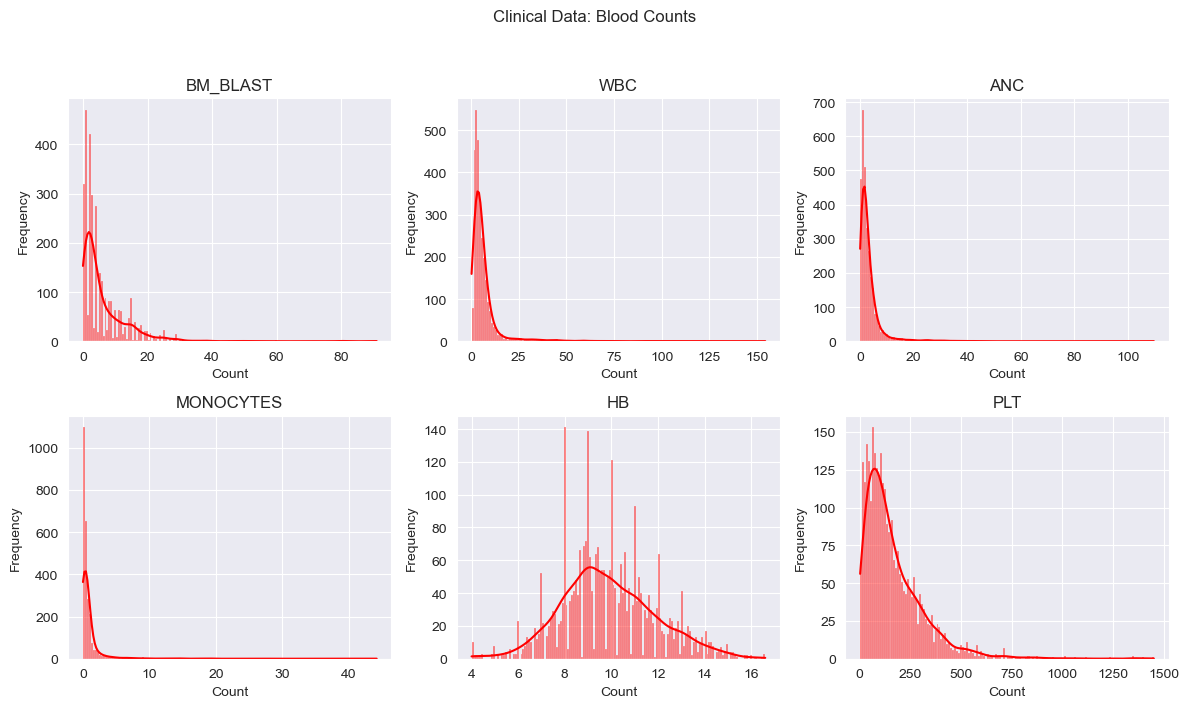

In [7]:
# Visualising clinical blood count data
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Clinical Data: Blood Counts")


axes = axes.flatten()

for i, feature in enumerate(features):  # first 3 features
    ax = axes[i]
    sns.histplot(Xc[feature], ax=ax, bins=150, kde=True, color="red")
    ax.set_xlabel(f"Count")
    ax.set_title(f"{feature}")
    ax.set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0.1, 1, 0.95]);
plt.show();



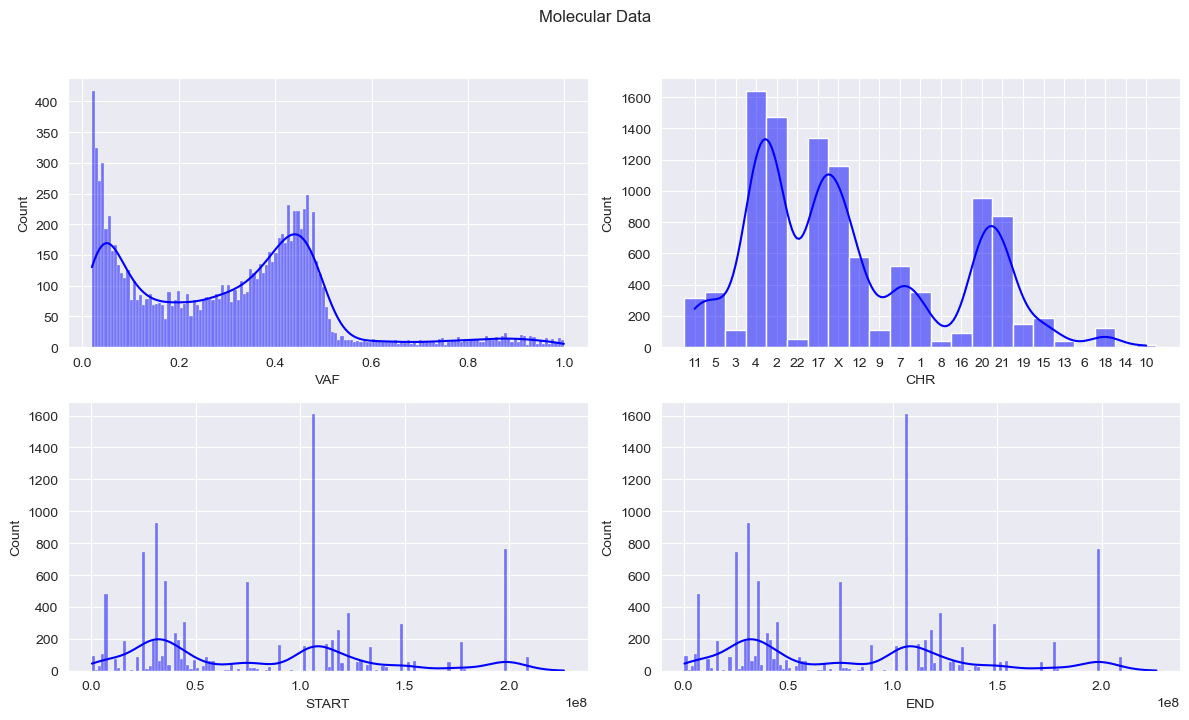

In [8]:
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 8));
fig1.suptitle("Molecular Data");

axes1 = axes1.flatten();
sns.histplot(Xm['VAF'], ax=axes1[0], bins=150, kde=True, color="blue")
sns.histplot(Xm['CHR'], ax=axes1[1], bins=150, kde=True, color="blue")
sns.histplot(Xm['START'], ax=axes1[2], bins=150, kde=True, color="blue")
sns.histplot(Xm['END'], ax=axes1[3], bins=150, kde=True, color="blue")

plt.tight_layout(rect=[0, 0.085, 1, 0.95]);
plt.show();

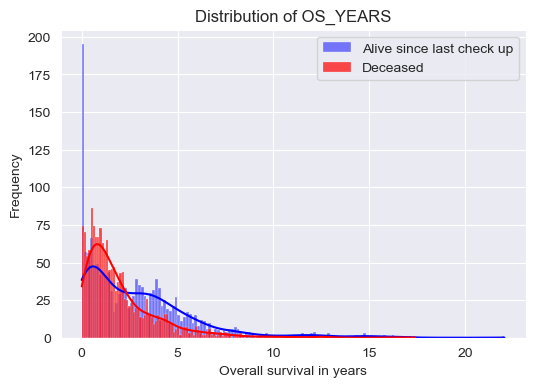

In [9]:
os_fig = plt.figure(figsize=(6, 4))
sns.histplot(y[y['OS_STATUS'] == 0]['OS_YEARS'], bins=150, kde=True, color="blue", label='Alive since last check up')
sns.histplot(y[y['OS_STATUS'] == 1]['OS_YEARS'], bins=150, kde=True, color="red", alpha=.7, label='Deceased')
plt.xlabel("Overall survival in years")
plt.ylabel("Frequency")
plt.title("Distribution of OS_YEARS")
plt.legend();
plt.show()

# Molecular Data Analysis

## The molecular data is slightly more complicated, with duplicated IDs and non-numerical data.

Let's first try to aggregate VAF and divide by the total number of mutations, which effectively would represent the overall proportion of cells with deleterious mutations.

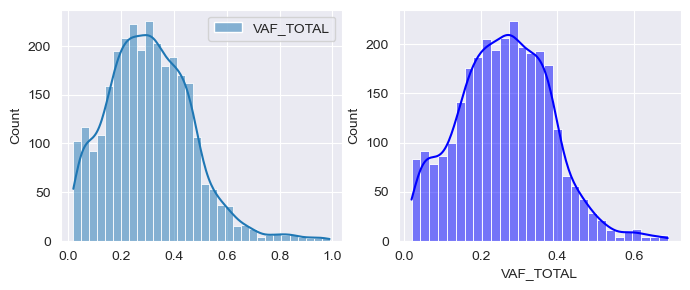

In [10]:
df_VAF_tot = pd.DataFrame([Xm[Xm['ID'] == patient_id]['VAF'].mean() for patient_id in target_train['ID']], columns=['VAF_TOTAL'], index=target_train['ID'])  # why the fuck is divided by 5 in there


fig2, axes4 = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(df_VAF_tot, kde=True, ax=axes4[0], color="red")

df_VAF_tot = np.log1p(df_VAF_tot['VAF_TOTAL'])
sns.histplot(df_VAF_tot, kde=True, ax=axes4[1], color="blue")

plt.show();

In [11]:
tmp = m_train.groupby('ID').size().reset_index(name='NMUT')
tmp_2 = c_train.merge(tmp, on='ID', how='left').fillna({'NMUT': 0})
features = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 'NMUT']

In [12]:
# Recreating survival data format
X_tmp = tmp_2.loc[tmp_2.ID.isin(target_train['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_train)

In [13]:
X = pd.concat([X_tmp.reset_index(drop=True), df_VAF_tot.reset_index(drop=True)], axis=1).fillna({'VAF_TOTAL': 0})

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [15]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

In [16]:
X_train['BM_BLAST'] = np.log1p(X_train['BM_BLAST'])
X_train['WBC'] = np.log1p(X_train['WBC'])
X_train['HB'] = np.log1p(X_train['HB'])
X_train['PLT'] = np.log1p(X_train['PLT'])
X_train['MONOCYTES'] = np.log1p(X_train['MONOCYTES'])
X_train['ANC'] = np.log1p(X_train['ANC'])

X_test['BM_BLAST'] = np.log1p(X_test['BM_BLAST'])
X_test['WBC'] = np.log1p(X_test['WBC'])
X_test['HB'] = np.log1p(X_test['HB'])
X_test['PLT'] = np.log1p(X_test['PLT'])
X_test['ANC'] = np.log1p(X_test['ANC'])

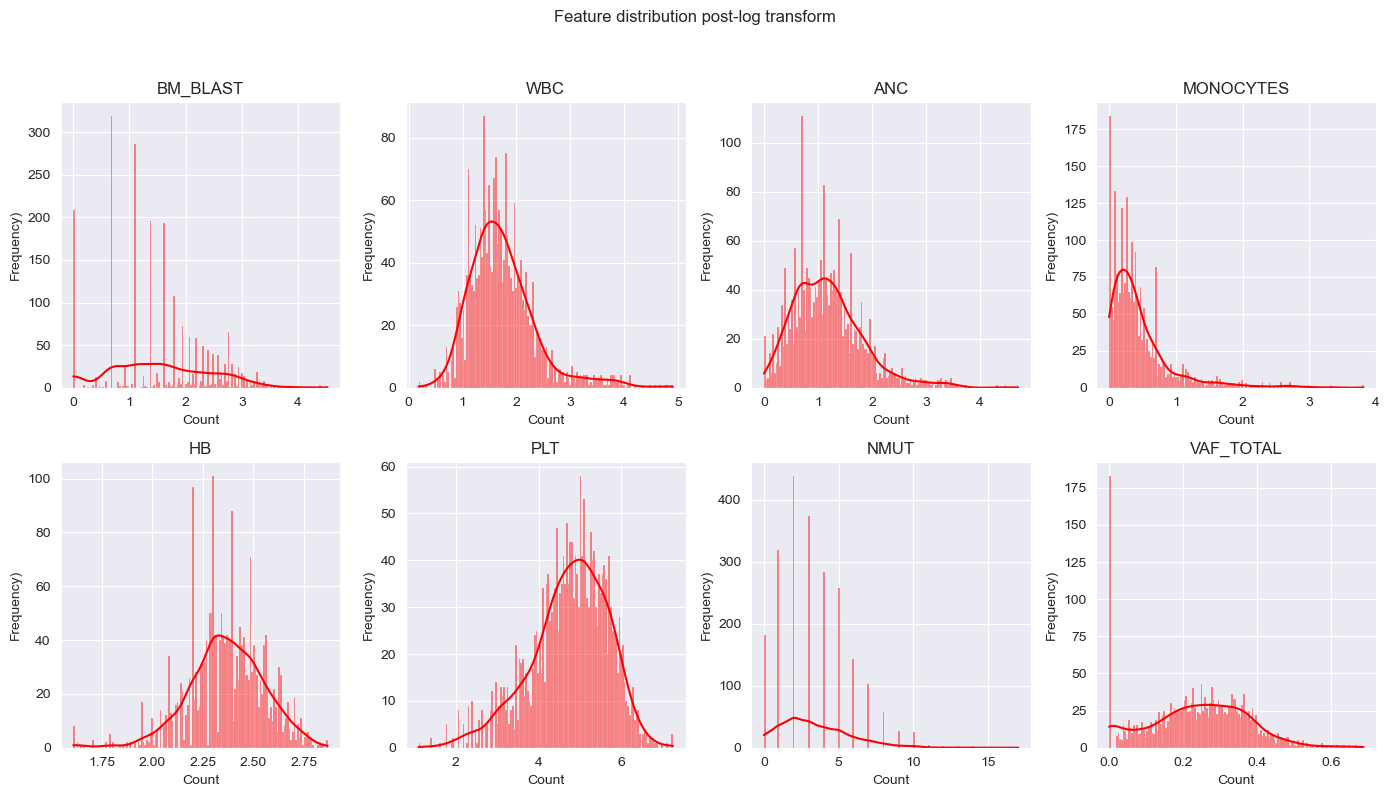

In [17]:
# Visualising again
fig, axes = plt.subplots(2, 4, figsize=(14, 9))
fig.suptitle("Feature distribution post-log transform")
features = X_train.columns
axes = axes.flatten()

for i, feature in enumerate(features):  # first 3 features
    ax = axes[i]
    sns.histplot(X_train[feature], ax=ax, bins=150, kde=True, color="red")
    ax.set_xlabel(f"Count")
    ax.set_title(f"{feature}")
    ax.set_ylabel("Frequency)")

plt.tight_layout(rect=[0, 0.1, 1, 0.95]);
plt.show();

## 3. Training the model, leveraging censored observations

In [18]:
y_train_trans = y_train['OS_YEARS']
y_test_trans = y_test['OS_YEARS']

# Applying log transform to OS_YEARS
y_train_trans = np.log1p(y_train_trans)
y_test_trans = np.log1p(y_test_trans)

# OS_STATUS weight function
w = 0.9 # weighting for deceased patients
weights = w * y_train['OS_STATUS'] + (1 - w)


## 3.1 LightGBM Model

In [19]:
# LightGBM dataset
X_train_lgb = X_train

wl = 0.4 # weighting for deceased patients
weights_lgbm = wl * y_train['OS_STATUS'] + (1 - wl)

X_lgb = lgb.Dataset(X_train_lgb, label=y_train_trans, weight=weights_lgbm)

# LGBM model
params_lgbm = {'verbose': -1,
               'learning_rate': 0.05,
               'max_depth': 2,
               'num_boost_round': 100}

lgbm = lgb.train(params=params_lgbm, train_set=X_lgb)

# LGBM predictions
pred_train_lgbm = -lgbm.predict(X_train)
pred_test_lgbm = -lgbm.predict(X_test)

train_ci_ipcw_lgbm = concordance_index_ipcw(y_train, y_train, np.expm1(pred_train_lgbm), tau=7)[0]
test_ci_ipcw_lgbm = concordance_index_ipcw(y_train, y_test, np.expm1(pred_test_lgbm), tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw_lgbm:.6f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw_lgbm:.6f}")

LightGBM Survival Model Concordance Index IPCW on train: 0.714941
LightGBM Survival Model Concordance Index IPCW on test: 0.682190


C:\Users\johnn\anaconda3\envs\venv_cmapss\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


5## 3.3 Random Survival Forests

In [20]:
from sksurv.ensemble import RandomSurvivalForest

# Initialise Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=200,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=2)

# Fit model
rsf.fit(X_train, y_train)

# Should I inverse log1p transform the predictions back? Makes sense to
# Predictions
rsf_pred_train = rsf.predict(X_train)
rsf_pred_test = rsf.predict(X_test)


In [21]:
# Evaluate
cox_ipcw_rsf_train = concordance_index_ipcw(y_train, y_train, rsf_pred_train, tau=7)[0]
cox_ipcw_rsf_test = concordance_index_ipcw(y_train, y_test, rsf_pred_test, tau=7)[0]
print(f"Random Survival Forests Concordance Index IPCW on train: {cox_ipcw_rsf_train:.6f}")
print(f"Random Survival Forests Concordance Index IPCW on test: {cox_ipcw_rsf_test:.6f}")
print(f"RSF self-score: ", rsf.score(X_test, y_test))

Random Survival Forests Concordance Index IPCW on train: 0.767491
Random Survival Forests Concordance Index IPCW on test: 0.681196
RSF self-score:  0.695284688418325


In [22]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.6f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.6f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.696098
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.664846


In [23]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis

In [24]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train, y_train)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(X_train.columns)

In [25]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

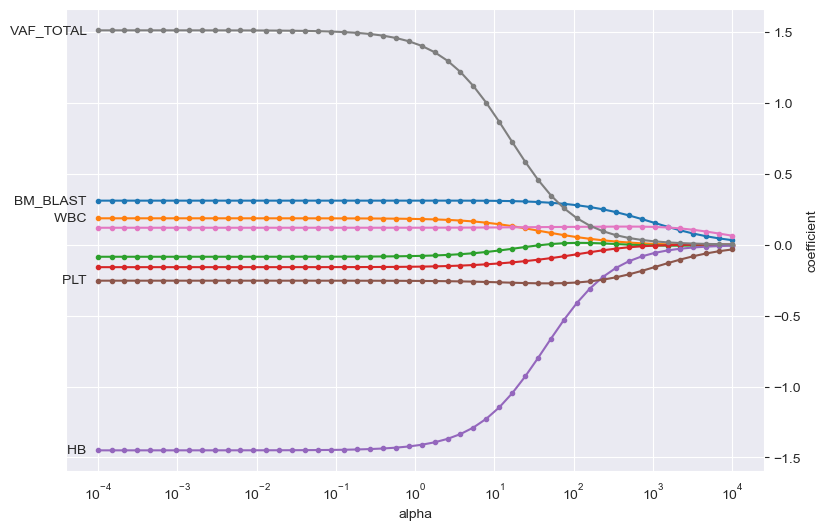

In [26]:
plot_coefficients(coefficients, n_highlight=5)

We can see that VAF_TOTAL and HB may be more important than the other variables when it comes to predicting the survival time since they diverge away from the other coefficients very quickly.

In [27]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_lasso.fit(X_train, y_train)


CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

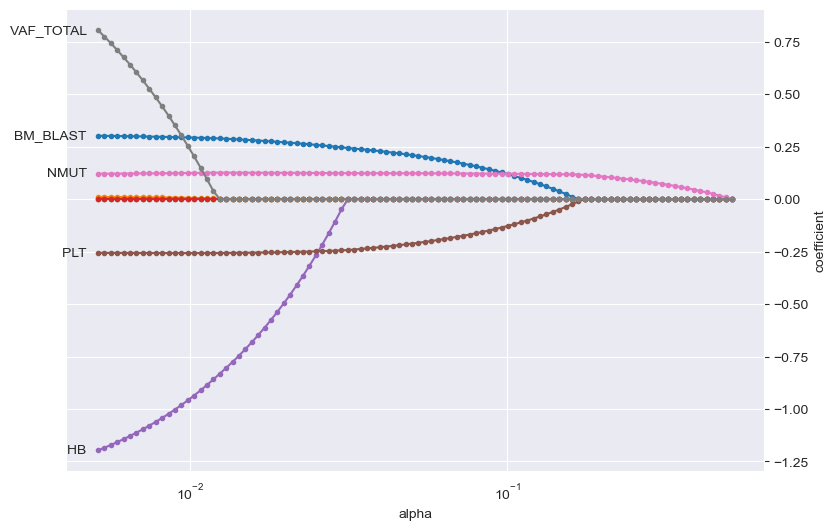

In [28]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=X_train.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

# Gradient Boosted Survival Analysis

In [118]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.2, max_depth=2, random_state=3)
est_cph_tree.fit(X_train, y_train)
pre_log = est_cph_tree.predict(X_test)
post_log = np.expm1(pre_log)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 6))
print(concordance_index_ipcw(y_train, y_test, post_log, tau=7)[0])

0.698101
0.6829404971763976


In [30]:
# Optimal number of estimators
scores_cph_tree = {}
for i in range(1, 10):
    n_estimators = i * 5
    est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=n_estimators, learning_rate=1.0, max_depth=2, random_state=1)
    est_cph_tree.fit(X_train, y_train)
    cindex = est_cph_tree.score(X_test, y_test)
    scores_cph_tree[n_estimators] = cindex
n_est_opt = max(scores_cph_tree, key = scores_cph_tree.get)

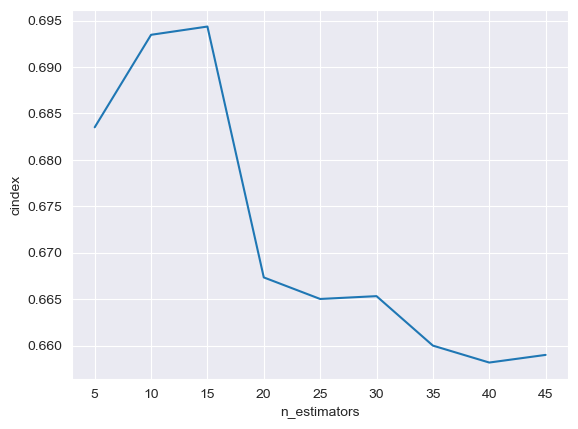

In [31]:
# Plotting n_estimators against c_index score
xx, yy = zip(*scores_cph_tree.items())
plt.plot(xx, yy)
plt.xlabel("n_estimators")
plt.ylabel("cindex")
plt.grid(True)
plt.show();


In [32]:
# Optimal number of estimators
scores_cph_tree_depth = {}
for i in range(1, 20):
    max_depth = i
    est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=n_est_opt, learning_rate=1.0, max_depth=max_depth, random_state=1)
    est_cph_tree.fit(X_train, y_train)
    cindex = est_cph_tree.score(X_test, y_test)
    scores_cph_tree_depth[max_depth] = cindex
opt_depth = max(scores_cph_tree_depth, key = scores_cph_tree_depth.get)


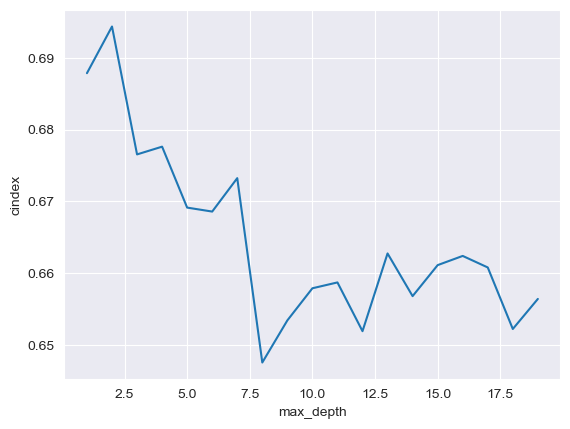

In [33]:
xx, yy = zip(*scores_cph_tree_depth.items())
plt.plot(xx, yy)
plt.xlabel("max_depth")
plt.ylabel("cindex")
plt.grid(True)
plt.show();

In [34]:
# K-fold cross validation
from sklearn.model_selection import KFold

In [35]:
kf = KFold(n_splits=10, shuffle=True, random_state=2)
c_index_scores = []
ipcw_c_scores = []
for train, val in kf.split(X_train):
    # Create folds
    X_train_fold, X_val_fold = X_train.iloc[train], X_train.iloc[val]
    y_train_fold, y_val_fold = y_train[train], y_train[val]

    # Train model
    model = GradientBoostingSurvivalAnalysis(n_estimators=25, learning_rate=0.2, max_depth=2, random_state=1)
    model.fit(X_train_fold, y_train_fold)

    # Evaluate with C-index and IPCW-C
    c_index_scores.append(model.score(X_val_fold, y_val_fold))
    ipcw_c = concordance_index_ipcw(y_train_fold, y_val_fold, model.predict(X_val_fold), tau=7)[0]
    ipcw_c_scores.append(ipcw_c)


In [36]:
print(f"Average concordance index score over 10 folds: {np.mean(c_index_scores)}")
print(f"Average IPCW-C score over 10 folds: {np.mean(ipcw_c_scores)}")

Average concordance index score over 10 folds: 0.7111301771816005
Average IPCW-C score over 10 folds: 0.690464107094835


# Preparing all training data for training final model

In [37]:
final_imputer = KNNImputer(n_neighbors=5)
features_ = ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 'NMUT',
       'VAF_TOTAL']

X = final_imputer.fit_transform(X)
X = pd.DataFrame(X, columns=features_)

for feature in features_:
    X[feature] = np.log1p(X[feature])

In [38]:
# Training the model on 100% of the training data
final_model = GradientBoostingSurvivalAnalysis(n_estimators=n_est_opt, learning_rate=0.2, max_depth=opt_depth)
print("Optimal number of estimators: ", n_est_opt)
print("Optimal max depth:", opt_depth)

# Training on ALL the training data
final_model.fit(X, y)

Optimal number of estimators:  15
Optimal max depth: 2


GradientBoostingSurvivalAnalysis(learning_rate=0.2, max_depth=2,
                                 n_estimators=15)

# Preparing test data features

In [99]:
# Adding VAF feature
VAF_tot = pd.DataFrame([m_test[m_test['ID'] == patient_id]['VAF'].mean() for patient_id in c_test['ID'].unique()], columns=['VAF_TOTAL'], index=c_test['ID'].unique())


In [100]:
tmp = m_test.groupby('ID').size().reset_index(name='NMUT')

In [101]:
tmp_2 = c_test.merge(tmp, on='ID', how='left').fillna({'NMUT': 0})


In [102]:
tmp_2.drop(['CENTER', 'CYTOGENETICS'], axis=1, inplace=True)

In [103]:
X_test_new = pd.concat([tmp_2.reset_index(drop=True), VAF_tot.reset_index(drop=True)], axis=1).fillna({'VAF_TOTAL': 0})

In [104]:
test_imputer = KNNImputer(n_neighbors=5)
X_test_new[features] = test_imputer.fit_transform(X_test_new[features])

In [108]:
X_test_new[features] = np.log1p(X_test_new[features])

In [109]:
# Final Gradient Boosted Survival Analysis for submission

test_predictions = final_model.predict(X_test_new[features])
# Submission file
submission = pd.Series(test_predictions, index=X_test_new['ID'], name='risk_score')

In [110]:
submission

ID
KYW1       0.692031
KYW2       0.653556
KYW3       0.269356
KYW4       0.692031
KYW5       0.034262
             ...   
KYW1189    0.654474
KYW1190    0.433391
KYW1191    0.402589
KYW1192    0.433391
KYW1193    0.334660
Name: risk_score, Length: 1193, dtype: float64

In [120]:
submission.to_csv("./submission.csv")

In [121]:
# Saving the model
import joblib

In [123]:
joblib.dump(final_model, "./final_model.pkl")

['./final_model.pkl']